In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# =============================
# Section 1: Setup and Imports
# =============================
nltk.download('punkt')
nltk.download('stopwords')

# URL of the dataset
url = 'https://raw.githubusercontent.com/ShoRit/face-acts/master/data/Persuasion%20Face%20Act%20Prediction.xlsx'


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# =============================
# Section 2: Data Loading
# =============================
# Read the Excel file from the provided URL
data = pd.read_excel(url, sheet_name=None)  # sheet_name=None reads all sheets into a dictionary

# Load the specific sheet for analysis
df = data['Predicted face acts']

# Display information about the dataset
print("Dataset Info:")
df.info()
print("\nFirst 5 rows of the dataset:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   conversation_id  10716 non-null  int64  
 1   speaker          10716 non-null  int64  
 2   utterance        10716 non-null  object 
 3   predicted_face   10716 non-null  object 
 4   true_face        10716 non-null  object 
 5   actual_donation  10716 non-null  int64  
 6   donation_prob    10716 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 586.2+ KB

First 5 rows of the dataset:
   conversation_id  speaker  \
0              120        0   
1              120        0   
2              120        1   
3              120        0   
4              120        1   

                                           utterance predicted_face true_face  \
0                                                Hi!          other     other   
1  Have you heard of 

In [ ]:
# Number of unique utterances
unique_utterances = df['utterance'].nunique()
print("Number of unique utterances:", unique_utterances)

# Number of unique conversations
unique_conversations = df['conversation_id'].nunique()
print("Number of unique conversations:", unique_conversations)


Number of unique utterances: 9574
Number of unique conversations: 296


In [ ]:
# Total number of occurrences (i.e., total number of rows/utterances in the dataset)
total_occurrences = len(df)
print("Total occurrences (utterances):", total_occurrences)

# Total number of conversations (unique conversation IDs)
total_unique_conversations = df['conversation_id'].nunique()
print("Number of unique conversations:", total_unique_conversations)

# If you want to see how many utterances each conversation has,
# use value_counts() to count occurrences per conversation_id.
conversation_counts = df['conversation_id'].value_counts()
print("\nOccurrences per conversation:")
print(conversation_counts)

# If you want the total sum of utterances across all conversations (which is the same as total occurrences):
total_occurrences_again = conversation_counts.sum()
print("\nTotal utterances across all conversations (should match total_occurrences):", total_occurrences_again)


Total occurrences (utterances): 10716
Number of unique conversations: 296

Occurrences per conversation:
conversation_id
225    76
161    71
26     66
195    66
222    65
       ..
295    20
224    20
96     20
269    20
91     20
Name: count, Length: 296, dtype: int64

Total utterances across all conversations (should match total_occurrences): 10716


In [ ]:
# =============================
# Section 3: Text Preprocessing
# =============================
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Lowercase
        text = re.sub(r'\W', ' ', text)  # Remove punctuation and non-word chars
        tokens = word_tokenize(text)  # Tokenize
        tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
        return ' '.join(tokens)
    else:
        return ''

# Apply preprocessing
df['utterance_cleaned'] = df['utterance'].apply(preprocess_text)

# Fit the label encoder once on true_face
label_encoder = LabelEncoder()
label_encoder.fit(df['true_face'])

# Transform both predicted_face and true_face using the same encoder
df['true_face_encoded'] = label_encoder.transform(df['true_face'])
df['predicted_face_encoded'] = label_encoder.transform(df['predicted_face'])

print("\nFirst 5 rows after preprocessing and encoding:")
print(df.head())
print("Classes:", label_encoder.classes_)


First 5 rows after preprocessing and encoding:
   conversation_id  speaker  \
0              120        0   
1              120        0   
2              120        1   
3              120        0   
4              120        1   

                                           utterance predicted_face true_face  \
0                                                Hi!          other     other   
1  Have you heard of an organization called Save ...          other     other   
2  I think I have once before, in a grocery store...          spos+     hpos+   
3  Do you mind if i give you a little information...          hneg-     hneg-   
4                                     Sure, go ahead          hpos+     hpos+   

   actual_donation  donation_prob                        utterance_cleaned  \
0                1       0.449824                                       hi   
1                1       0.809971  heard organization called save children   
2                1       0.452638           

In [ ]:
# =============================
# Section 4: Data Splitting
# =============================
X = df['utterance_cleaned']
Y = df['true_face_encoded']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)




In [ ]:
# =============================
# Section 5: Class Balancing
# =============================
train_data = pd.DataFrame({'utterance_cleaned': X_train, 'true_face_encoded': Y_train})
grouped = train_data.groupby('true_face_encoded', group_keys=False)
max_size = grouped.size().max()

balanced_data = grouped.apply(
    lambda x: resample(x, replace=True, n_samples=max_size, random_state=42)
).reset_index(drop=True)

X_train_balanced = balanced_data['utterance_cleaned']
Y_train_balanced = balanced_data['true_face_encoded']

print("Class distribution after balancing:")
print(Y_train_balanced.value_counts())



Class distribution after balancing:
true_face_encoded
0    2993
1    2993
2    2993
3    2993
4    2993
5    2993
6    2993
7    2993
Name: count, dtype: int64


<ipython-input-17-834973d71d4d>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = grouped.apply(


In [ ]:
# =============================
# Section 6: Embedding Extraction with GPT-2
# =============================
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token  # Set padding token for GPT-2
gpt2_model = TFAutoModel.from_pretrained(model_name)

def get_gpt2_embeddings(text_list, batch_size=16):
    embeddings_list = []
    for i in range(0, len(text_list), batch_size):
        batch_texts = text_list[i:i + batch_size]
        encodings = tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True, max_length=100)
        outputs = gpt2_model(encodings['input_ids'])
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings_list.append(batch_embeddings)
    return tf.concat(embeddings_list, axis=0)

X_train_embeddings = get_gpt2_embeddings(X_train_balanced.tolist())
X_test_embeddings = get_gpt2_embeddings(X_test.tolist())

All PyTorch model weights were used when initializing TFGPT2Model.

All the weights of TFGPT2Model were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
# =============================
# Section 7: Fine-tuning GPT-2 for Sequence Classification
# =============================
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

model = TFAutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_encoder.classes_)
)

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=100, return_tensors="tf")

train_labels = tf.convert_to_tensor(Y_train.values, dtype=tf.int32)
test_labels = tf.convert_to_tensor(Y_test.values, dtype=tf.int32)

train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    train_labels
)).shuffle(1000).batch(8)

test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"]
    },
    test_labels
)).batch(8)

# Modify the model to include dropout
class GPT2SequenceClassificationWithDropout(tf.keras.Model):
    def __init__(self, base_model, num_labels):
        super(GPT2SequenceClassificationWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = tf.keras.layers.Dropout(0.3)  # Dropout for regularization
        self.classifier = tf.keras.layers.Dense(num_labels)

    def call(self, inputs, training=False):
        outputs = self.base_model(inputs, training=training)
        # outputs.last_hidden_state: (batch_size, seq_length, hidden_size)
        logits = outputs.last_hidden_state
        # Pooling by average over sequence
        pooled_logits = tf.reduce_mean(logits, axis=1)
        pooled_logits = self.dropout(pooled_logits, training=training)
        final_logits = self.classifier(pooled_logits)
        return final_logits

num_labels = len(label_encoder.classes_)
base_model = model.transformer
pooled_model = GPT2SequenceClassificationWithDropout(base_model, num_labels)

optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-5, weight_decay=1e-4)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

pooled_model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = pooled_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10,
    callbacks=[early_stopping]
)

All PyTorch model weights were used when initializing TFGPT2ForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFGPT2ForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 91s 68ms/step - accuracy: 0.0581 - loss: 18.8980 - val_accuracy: 0.3036 - val_loss: 6.1232
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.2315 - loss: 6.2262 - val_accuracy: 0.3913 - val_loss: 2.4414
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 74s 39ms/step - accuracy: 0.2744 - loss: 3.5529 - val_accuracy: 0.3935 - val_loss: 1.8139
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.2911 - loss: 2.6343 - val_accuracy: 0.3944 - val_loss: 1.6955
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.3345 - loss: 2.1486 - val_accuracy: 0.4040 - val_loss: 1.6280
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.3407 - loss: 1.9537 - val_accuracy: 0.4146 - val_loss: 1.5587
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.3349 - loss: 1.8491 - val_accuracy: 0.4184 - val_loss: 1.5074
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.3561 - loss: 1.7316 -

In [4]:
# =============================
# Section 8: Evaluate and Analyze the Model
# =============================
test_predictions = pooled_model.predict(test_dataset)
y_pred = np.argmax(test_predictions, axis=1)
y_true = Y_test.values

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

       hneg+       0.42      0.50      0.46       319
       hneg-       0.61      0.49      0.54       618
       hpos+       0.75      0.46      0.57       965
       hpos-       0.27      0.46      0.34       182
       other       0.52      0.48      0.50       489
       sneg+       0.43      0.44      0.44       323
       spos+       0.26      0.50      0.34       155
       spos-       0.28      0.57      0.37       164

    accuracy                           0.48      3215
   macro avg       0.44      0.49      0.44      3215
weighted avg       0.55      0.48      0.50      3215



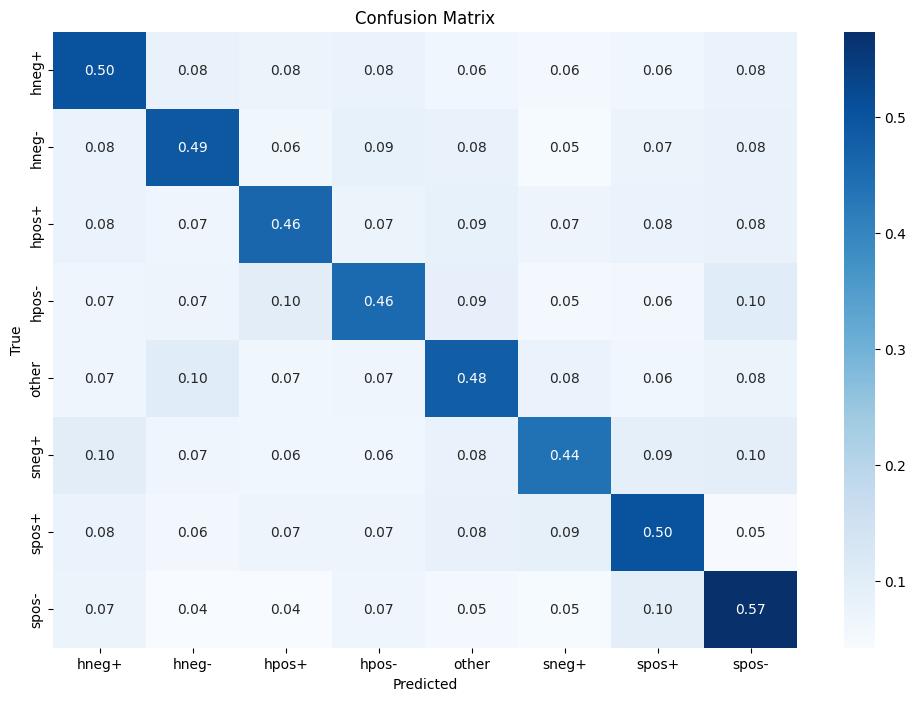

In [5]:
# =============================
# Section 9: Confusion Matrix
# =============================

conf_matrix = confusion_matrix(y_true, y_pred, labels=range(len(label_encoder.classes_)))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
